# Caso de Estudio: Deflexión de una Viga con Diferencias Finitas
 
Este notebook resuelve una ecuación diferencial ordinaria (EDO) que modela la deflexión de una viga con carga uniforme. Se utiliza el **Método de Diferencias Finitas (MDF)** para transformar la EDO en un sistema de ecuaciones algebraicas lineales, que luego se resuelve numéricamente.

### Problema Físico

El balance de fuerzas para una viga con carga uniforme resulta en la siguiente EDO:
$$EI\dfrac{d^{2}y}{dx^{2}}=\dfrac{wL}{2}x-\dfrac{w}{2}x^{2}$$

Donde:
- $x$: distancia a lo largo de la viga ($m$)
- $y$: deflexión ($m$)
- $L$: longitud de la viga ($m$)
- $E$: módulo de elasticidad ($N/m^2$)
- $I$: momento de inercia ($m^4$)
- $w$: carga uniforme ($N/m$)


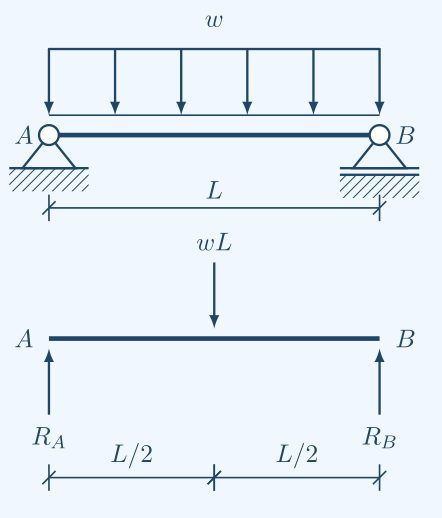

### Objetivos
 
 1.  **Discretizar** la EDO usando una aproximación en diferencia centrada.
 2.  **Implementar** una función en Python para construir y resolver el sistema de ecuaciones resultante.
 3.  **Verificar** la solución numérica comparándola con la solución analítica exacta.

Pruebe su script con los siguientes valores de parámetro: $L=3\,m$, $\Delta x= 0.2\,m$, $E=250\times 10^{9}\,N/m^{2}$, $I=3\times10^{-4}m^{4}$, $w=22500\,N/m$, $y(0)$ y $y(L)=0$

___
 
 ## Paso 1: Discretización de la EDO

Para resolver la EDO numéricamente, primero la discretizamos. Dividimos la viga en `n+1` segmentos de igual longitud `Δx`, creando `n` nodos interiores donde la deflexión es desconocida.

La segunda derivada se aproxima usando la fórmula de **diferencia centrada**:
$$\dfrac{d^{2}y}{dx^{2}} \approx \dfrac{y_{i+1}-2y_{i}+y_{i-1}}{\Delta x^{2}}$$

Sustituyendo esta aproximación en la EDO original y reordenando los términos, obtenemos una ecuación algebraica para cada nodo interior `i`:

$$ \left(\frac{EI}{\Delta x^{2}}\right)y_{i-1} - 2\left(\frac{EI}{\Delta x^{2}}\right)y_{i} + \left(\frac{EI}{\Delta x^{2}}\right)y_{i+1} = \dfrac{wL}{2}x_i - \dfrac{w}{2}x_i^{2} $$

Al aplicar esta ecuación a cada uno de los `n` nodos interiores, generamos un sistema de `n` ecuaciones lineales con `n` incógnitas ($y_1, y_2, ..., y_n$). Este sistema se puede escribir en forma matricial como:

$$ [A]\{y\} = \{b\} $$

Donde `[A]` es una matriz **tridiagonal** de coeficientes, `{y}` es el vector de deflexiones desconocidas y `{b}` es el vector de términos independientes que incluye el efecto de la carga y las condiciones de frontera.

---

## Paso 2: Implementación en Python

A continuación, se desarrolla una función de Python para resolver este sistema de ecuaciones.



In [1]:
from mnspy import Gauss
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def viga(E: float, I: float, w: float, y0: float, yl: float, L: float, n: int) -> dict:
 """
 Resuelve la deflexión de una viga con carga uniforme usando diferencias finitas.

 Args:
     E (float): Módulo de elasticidad (N/m^2).
     I (float): Momento de inercia (m^4).
     w (float): Carga uniforme (N/m).
     y0 (float): Deflexión en x=0 (m), condición de frontera.
     yl (float): Deflexión en x=L (m), condición de frontera.
     L (float): Longitud de la viga (m).
     n (int): Número de nodos interiores.

 Returns:
     dict: Un diccionario con las listas de posiciones 'x' y deflexiones 'y'.
 """
 # 1. Parámetros de la discretización
 delta_x = L / (n + 1)
 x_nodos = np.linspace(0, L, n + 2)  # Coordenadas de todos los nodos (incluyendo fronteras)

 # 2. Construcción de la matriz tridiagonal [A] de n x n
 A = np.zeros((n, n))
 
 # Coeficientes de la ecuación discretizada
 c1 = E * I / delta_x**2
 c2 = -2 * E * I / delta_x**2
 
 # Rellenamos las diagonales de la matriz A
 np.fill_diagonal(A, c2)          # Diagonal principal
 np.fill_diagonal(A[1:], c1)      # Diagonal inferior
 np.fill_diagonal(A[:, 1:], c1)    # Diagonal superior

 # 3. Construcción del vector de términos independientes {b}
 b = np.zeros((n, 1))
 for i in range(n):
     # El índice del nodo en la discretización es (i+1)
     x_i = x_nodos[i+1]
     b[i, 0] = (w * L / 2) * x_i - (w / 2) * x_i**2

 # 4. Aplicación de las condiciones de frontera (Dirichlet)
 # Los términos conocidos (y0 y yL) se mueven al lado derecho del sistema
 b[0, 0] -= c1 * y0
 b[-1, 0] -= c1 * yl

 # 5. Solución del sistema de ecuaciones
 # La matriz A es tridiagonal, por lo que se podría usar un solver más eficiente (ej. Algoritmo de Thomas).
 # Para este caso de estudio, la Eliminación Gaussiana es suficiente.
 solver = Gauss(A, b)
 y_interior = solver.x.flatten().tolist()

 # 6. Ensamblaje de la solución completa (incluyendo fronteras)
 y_completa = [y0] + y_interior + [yl]
 
 return {'x': x_nodos.tolist(), 'y': y_completa}

___
## Paso 3: Solución Numérica y Visualización

Ahora, se invoca la función `viga` con los parámetros del problema y se grafica el resultado.

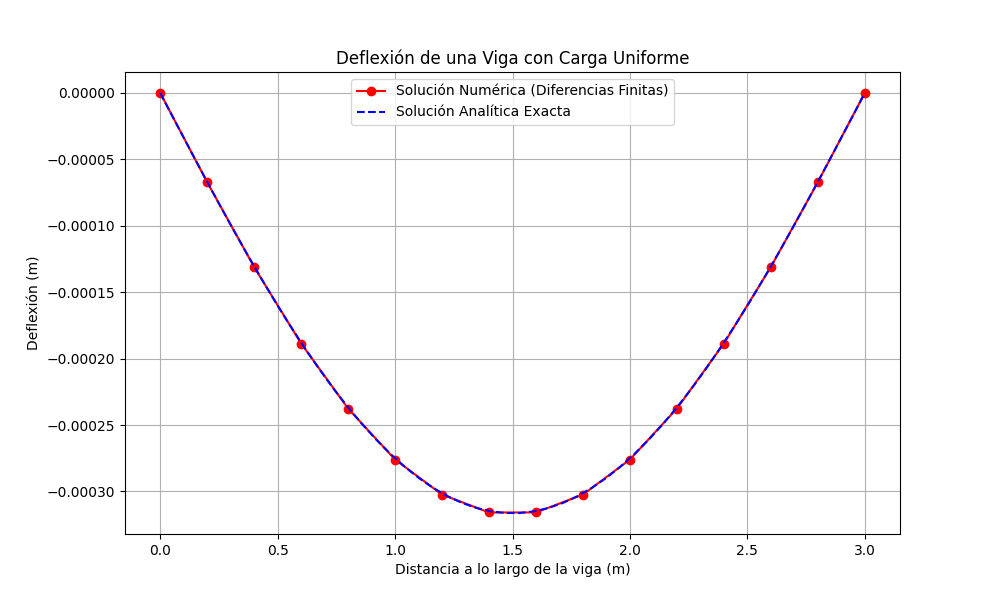

In [3]:
%matplotlib widget
 
# --- Parámetros del problema ---
E = 250E9
I = 3E-4
w = 22500
y0 = 0
yl = 0
L = 3

# Nota: El enunciado pide Δx = 0.2 m.
# Esto corresponde a n = (L/Δx) - 1 = (3/0.2) - 1 = 14 nodos interiores.
n = 14

# --- Solución Numérica ---
solucion_numerica = viga(E, I, w, y0, yl, L, n)

# --- Solución Analítica (para comparación) ---
# La solución analítica exacta se deriva integrando dos veces la EDO y aplicando las condiciones de frontera.
x_analitico = np.linspace(0, L)
y_analitico_func = lambda x: (-w / (24 * E * I)) * (x**4 - 2 * L * x**3 + L**3 * x) + ((yl - y0) / L) * x + y0
y_analitico = y_analitico_func(x_analitico)

# --- Gráfica Comparativa ---
plt.figure(figsize=(10, 6))
plt.plot(solucion_numerica['x'], solucion_numerica['y'], 'o-', c='r', label='Solución Numérica (Diferencias Finitas)')
plt.plot(x_analitico, y_analitico, c='b', linestyle='--', label='Solución Analítica Exacta')
plt.grid()
plt.title('Deflexión de una Viga con Carga Uniforme')
plt.xlabel('Distancia a lo largo de la viga (m)')
plt.ylabel('Deflexión (m)')
plt.legend()
plt.show()

___

## Paso 4: Comparación Numérica

Para un análisis más detallado, se presenta una tabla que compara los valores de la solución numérica y la analítica en cada uno de los nodos de la discretización.

In [4]:
import pandas as pd

# Extraer datos de la solución numérica
x_numerico = solucion_numerica['x']
y_numerico = solucion_numerica['y']

# Calcular la solución analítica en los mismos puntos que la numérica
y_analitico_en_puntos = y_analitico_func(np.array(x_numerico))

# Crear el DataFrame
df_comparacion = pd.DataFrame({
 'Posición (x)': x_numerico,
 'Solución Numérica (y)': y_numerico,
 'Solución Analítica (y)': y_analitico_en_puntos
})

# Mostrar la tabla
df_comparacion

,Posición (x),Solución Numérica (y),Solución Analítica (y)
0,0.0,0.000000,0.000000
1,0.2,-0.000067,-0.000067
2,0.4,-0.000131,-0.000131
3,0.6,-0.000189,-0.000188
4,0.8,-0.000238,-0.000237
5,1.0,-0.000276,-0.000275
6,1.2,-0.000302,-0.000301
7,1.4,-0.000316,-0.000315
8,1.6,-0.000316,-0.000315
9,1.8,-0.000302,-0.000301


___

## Paso 5: Conclusión

La gráfica y la tabla muestran una excelente concordancia entre la solución numérica obtenida con el método de diferencias finitas y la solución analítica exacta. Esto verifica que nuestra implementación es correcta y que el método es adecuado para resolver este tipo de problema de valor de frontera.